In [27]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

In [28]:
# 准备数据
X, y = make_classification(n_samples=10000, n_features=20, n_informative=10, n_classes=5, random_state=0)

In [29]:
# 人为增加噪声
np.random.seed(0)
nosie = np.random.randn(*X.shape) * 0.1
# 噪声加在X上，这是一个分类问题，y是类别，没法加噪声
X += nosie

In [30]:
# 拆分数据集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [31]:
# 数据预处理
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0) + 1e-10
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

In [32]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        """
            初始化
        """
        self.X = X
        self.y = y

    def __len__(self):
        """
            返回数据集中样本的总个数
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
            用于索引数据
            - 注意：参与计算的必须是float32类型
            - 注意：索引的类型必须要是int64或者long的
        """
        # 特征数据是float32类型
        x_idx = torch.tensor(data=self.X[idx], dtype=torch.float32)
        # 标签数据是long类型
        y_idx = torch.tensor(data=self.y[idx], dtype=torch.long)
        return x_idx, y_idx

In [33]:
# 打包训练集
train_dataset = MyDataset(X=X_train, y=y_train)
# 定义一个数据集的加载器
# shuffle 表示是否打乱数据
# 如果数据集最后一批不够了，有两个策略，一种是丢弃，另一种是直接作为最后一批，通过drop_last=True来控制
# 普通的生成器只能被遍历一次；dataloader也是一个生成器，但是可以被遍历多次
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [34]:
# 打包测试集
test_dataset = MyDataset(X=X_test, y=y_test)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [40]:
# 自定义模型
from torch import nn
# 模型继承自 nn.Module
class Model(nn.Module):
    """自定义深度学习模型"""
    def __init__(self,n_features,n_classes) -> None:
        """初始化"""
        super(Model,self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        # 定义一个线性层，可以把100个特征变成了1个特征
        self.fc1 = nn.Linear(in_features=self.n_features, out_features=8)
        self.fc2 = nn.Linear(in_features=8, out_features=self.n_classes)

    def forward(self, x):
        """
        正向传播过程
            - x: 输入数据，形状为(batch_size, 100)
            - 返回值: 输出数据，形状为(batch_size, 1)
        """
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        return x
        

In [49]:
# 创建模型
model = Model(n_features=20,n_classes=5)
epochs = 100
learning_rate = 1e-1
# 分类问题不能使用MSE了
loss_fn = nn.CrossEntropyLoss()
# 优化器
# 优化器做了两个步骤：自动求偏导，清空梯度
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# 监控准确率
train_accs = []
test_accs = []

In [53]:
# 过程监控
def get_acc(dataloader, model):
    # 设置模型为评估模式
    model.eval()
    accs = []
    with torch.no_grad():
        for batch_x,batch_y in dataloader:
            # 原始输出
            y_pred = model(batch_x)
            # 输出类别
            y_pred = y_pred.argmax(dim=-1)
            # 准确率
            acc = (y_pred == batch_y).to(dtype=torch.float32).mean().item()
            accs.append(acc)
    return torch.tensor(data=accs,dtype=torch.float32).mean().item()

In [54]:
"""定义训练过程"""

def train(
        model=model, 
        dataloader = train_dataloader, 
        optimizer = optimizer,  
        loss_fn=loss_fn,
        epochs = epochs
        ):
    
    train_acc = get_acc(dataloader=train_dataloader,model=model)
    test_acc = get_acc(dataloader=test_dataloader,model=model)

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"在训练之前，模型的在训练集和测试集上的 acc 为 {train_acc:.4f} {test_acc:.4f}")
    
    
    for epoch in range(epochs):
        # 设置为训练模式
        model.train()
        for batch_idx,(batch_X,batch_y) in enumerate(dataloader):
            # print(f"当前正在训练 {epoch+1} 轮 当前批次为 {batch_idx+1}")
            # 正向传播
            y_pred = model(batch_X)
            # 计算损失
            loss = loss_fn(y_pred,batch_y)
            # 反向传播
            loss.backward()
            # 优化一步
            optimizer.step()
            # 清空梯度
            optimizer.zero_grad()
        # 本轮训练完成之后，计算mse
        train_acc = get_acc(dataloader=train_dataloader,model=model)
        test_acc = get_acc(dataloader=test_dataloader,model=model)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print(f"当前正在训练 {epoch+1} 轮 当前训练集 acc 为 {train_acc:.4f} 当前测试集 acc 为 {test_acc:.4f}")
        


In [55]:
train()

在训练之前，模型的在训练集和测试集上的 acc 为 0.7204 0.7303
当前正在训练 1 轮 当前训练集 acc 为 0.7211 当前测试集 acc 为 0.7284
当前正在训练 2 轮 当前训练集 acc 为 0.7238 当前测试集 acc 为 0.7302
当前正在训练 3 轮 当前训练集 acc 为 0.7228 当前测试集 acc 为 0.7287
当前正在训练 4 轮 当前训练集 acc 为 0.7242 当前测试集 acc 为 0.7310
当前正在训练 5 轮 当前训练集 acc 为 0.7230 当前测试集 acc 为 0.7288
当前正在训练 6 轮 当前训练集 acc 为 0.7226 当前测试集 acc 为 0.7289
当前正在训练 7 轮 当前训练集 acc 为 0.7225 当前测试集 acc 为 0.7297
当前正在训练 8 轮 当前训练集 acc 为 0.7228 当前测试集 acc 为 0.7254
当前正在训练 9 轮 当前训练集 acc 为 0.7257 当前测试集 acc 为 0.7328
当前正在训练 10 轮 当前训练集 acc 为 0.7251 当前测试集 acc 为 0.7326
当前正在训练 11 轮 当前训练集 acc 为 0.7235 当前测试集 acc 为 0.7270
当前正在训练 12 轮 当前训练集 acc 为 0.7225 当前测试集 acc 为 0.7293
当前正在训练 13 轮 当前训练集 acc 为 0.7227 当前测试集 acc 为 0.7292
当前正在训练 14 轮 当前训练集 acc 为 0.7231 当前测试集 acc 为 0.7271
当前正在训练 15 轮 当前训练集 acc 为 0.7257 当前测试集 acc 为 0.7240
当前正在训练 16 轮 当前训练集 acc 为 0.7250 当前测试集 acc 为 0.7287
当前正在训练 17 轮 当前训练集 acc 为 0.7267 当前测试集 acc 为 0.7329
当前正在训练 18 轮 当前训练集 acc 为 0.7274 当前测试集 acc 为 0.7316
当前正在训练 19 轮 当前训练集 acc 为 0.7266 当前测试集 acc 为 0.7276
当前正在训练 20 轮 当前训练集 a

In [25]:
 # 画图
from matplotlib import pyplot as plt

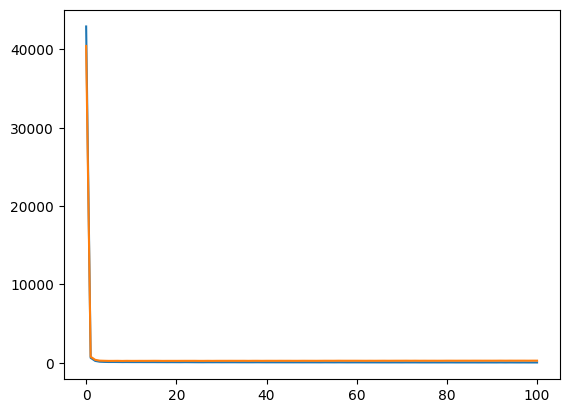

In [26]:
plt.plot(train_mses, label='Train MSE')
plt.plot(test_mses, label='Test MSE')   
# 这两个线重合了，因为是mock的假数据，数据训练效果太好了。

In [72]:
"""模型的保存与加载"""
model

Model(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
# 把模型的网络结构和权重保存在一起的
import joblib
joblib.dump(model, 'model.pkl')

In [ ]:
# 把模型的网络结构和权重保存在一起的
torch.save(model, 'model.torch')

In [ ]:
# 怎么把模型的网络结构和权重分开保存呢？
# 只保存权重
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# 加载模型
model1 = Model()
model1.load_state_dict(torch.load('model.pth'))

In [30]:
# 推理
def predit(X,model=model):
    if not isinstance(X,torch.Tensor):
        X = torch.tensor(X)
    if X.dim() != 2:
        raise ValueError('X must be a 2D tensor')
    
    # 数据预处理
    X = (X - torch.tensor(mu,dtype=torch.float32)) / torch.tensor(sigma,dtype=torch.float32)

    # 评估模式
    model.eval()

    with torch.no_grad():
        y_pred = model(X)
    
    return y_pred


In [34]:
x_to_test,y_to_test = test_dataset[0]
y_pred = predit(X=x_to_test.unsqueeze(dim=0))
print(f'预测结果为：{y_pred}，真实结果为：{y_to_test}')

预测结果为：tensor([[42.6767]])，真实结果为：tensor([46.6686])


In [9]:
# 假设模拟模型的输出是5个值。
# 但是这5个值并不是概率。因为模型输出的5个值是任意的。所以我们要把这个结果处理成概率。
y0 = torch.randn(5)

In [10]:
y0

tensor([2.6474, 0.0738, 0.7018, 0.2737, 1.2787])

In [12]:
# 怎么处理呢？ 先非负，在归一
torch.exp(y0) / torch.exp(y0).sum()

tensor([0.6383, 0.0487, 0.0912, 0.0594, 0.1624])

In [15]:
# 可以一步到位，使用softmax做概率模拟
y_pred = torch.softmax(y0,dim=0)

In [16]:
y_pred

tensor([0.6383, 0.0487, 0.0912, 0.0594, 0.1624])

In [17]:
# 假设真是结果是 第 2 类
y_true = 2

In [18]:
# 怎么衡量误差呢？
# 使用MSE，先把真实结果转成概率的形式
y_true = torch.tensor(data=[0,0,1,0,0],dtype=torch.float32)

In [19]:
y_true

tensor([0., 0., 1., 0., 0.])

In [20]:
y_pred

tensor([0.6383, 0.0487, 0.0912, 0.0594, 0.1624])

In [21]:
((y_true - y_pred) ** 2).mean()

tensor(0.2531)

In [23]:
# 第二种方式衡量误差：交叉熵
# 交叉熵：把两个概率的分布求差。处理的是两个概率的分布。从分布的角度处理的。
-(y_true * torch.log(y_pred)).sum(dim=-1)

tensor(2.3946)

In [26]:
# 交叉熵最简单的一种用法
from torch import nn
loss_fn = nn.CrossEntropyLoss()
# 模拟模型输出（2个样本，每个样本输出5个类别的概率）
y_pred = torch.randn(2, 5,requires_grad=True)
# 模拟真实结果（2个样本的标签）
y_true = torch.randint(5, (2,), dtype=torch.int64)
# 交叉熵的计算
loss_fn(y_pred, y_true)

tensor(2.5272, grad_fn=<NllLossBackward0>)